# Sample Lya posterior as a function of nuisance parameters

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import sys
import os
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 250
mpl.rcParams['figure.dpi'] = 250
import cProfile
import emcee
# our own modules
import simplest_emulator
import linear_emulator
import gp_emulator
import data_PD2013
import mean_flux_model
import thermal_model
import lya_theory
import likelihood

### Setup Lya likelihood function

In [2]:
# read P1D measurement
data=data_PD2013.P1D_PD2013(blind_data=True)
zs=data.z

In [3]:
basedir='../../p1d_emulator/sim_suites/emulator_15052019/'
p1d_label='p1d'
skewers_label='Ns110_wM0.1'
use_gp=True
if use_gp:
    emu=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,max_arxiv_size=1000,verbose=True,paramList=None,kmax_Mpc=5,train=True)
else:
    emu=linear_emulator.LinearEmulator(basedir,p1d_label,skewers_label,drop_tau_rescalings=False,drop_temp_rescalings=False,verbose=True)

latin hyper-cube data {'param_space': {'Om_star': {'ip': 0, 'min_val': 0.955, 'max_val': 0.975, 'z_star': 3.0, 'latex': '$\\Omega_\\star$'}, 'Delta2_star': {'ip': 1, 'min_val': 0.25, 'max_val': 0.45, 'z_star': 3.0, 'kp_Mpc': 0.7, 'latex': '$\\Delta^2_\\star$'}, 'n_star': {'ip': 2, 'min_val': -2.35, 'max_val': -2.25, 'z_star': 3.0, 'kp_Mpc': 0.7, 'latex': '$n_\\star$'}, 'alpha_star': {'ip': 3, 'min_val': -0.265, 'max_val': -0.165, 'z_star': 3.0, 'kp_Mpc': 0.7, 'latex': '$\\alpha_\\star$'}, 'mu_He': {'ip': 4, 'min_val': 0.5, 'max_val': 2.0, 'latex': '$\\mu_{\\rm He}$'}, 'mu_H': {'ip': 5, 'min_val': 0.5, 'max_val': 2.0, '   latex': '$\\mu_{\\rm H}$'}}, 'nsamples': 10, 'samples': {'0': [0.96, 0.32, -2.325, -0.22, 0.875, 1.7750000000000001], '1': [0.966, 0.4, -2.295, -0.23, 1.175, 0.575], '2': [0.968, 0.36, -2.285, -0.26, 1.7750000000000001, 1.625], '3': [0.97, 0.3, -2.315, -0.18, 1.3250000000000002, 1.3250000000000002], '4': [0.974, 0.34, -2.305, -0.21000000000000002, 1.475, 1.175], '5': [

In [4]:
# setup theory to predict Lya 1D power
theory = lya_theory.LyaTheory(zs,emulator=emu,verbose=True)
# for this simple test, just use fiducial cosmology
theory.set_cosmo_model(linP_model=theory.cosmo.linP_model_fid)
linP_Mpc_params=theory.cosmo.get_linP_Mpc_params()

Note: redshifts have been re-sorted (earliest first)
use default mean flux model
use default thermal model


In [5]:
# specify free parameters in likelihood
free_parameters=['ln_tau_0','ln_tau_1']
#free_parameters=['ln_tau_0','ln_tau_1','ln_T0_0']
#free_parameters=['ln_tau_0','ln_tau_1','ln_T0_0','ln_gamma_0']
#free_parameters=['ln_tau_0','ln_tau_1','ln_T0_0','ln_T0_1','ln_gamma_0','ln_gamma_1']

In [6]:
like=likelihood.Likelihood(data=data,theory=theory,free_parameters=free_parameters,verbose=True)

got parameters
g_star = 0.9677508579459803
f_star = 0.98136955784
Delta2_star = 0.360175905286
n_star = -2.29933566726
alpha_star = -0.216527037121
ln_tau_0 = -0.794580172414
ln_tau_1 = 3.18
ln_T0_0 = 9.21034037198
ln_T0_1 = 0.0
ln_gamma_0 = 0.336472236621
ln_gamma_1 = 0.0
likelihood setup with 2 free parameters
2 free parameters


In [7]:
for p in like.free_params:
    print(p.name,p.value)

ln_tau_0 -0.794580172414
ln_tau_1 3.18


In [8]:
like.go_silent()

### Setup MCMC to call this function

In [9]:
def log_prob(values,like,linP_Mpc_params,verbose=False):
    test_log_prob=like.log_prob(values=values,linP_Mpc_params=linP_Mpc_params)
    if np.isnan(test_log_prob):
        if verbose:
            print('parameter values outside hull',values)
        return -np.inf
    return test_log_prob

In [10]:
def setup_walkers(ndim,nwalkers,like,linP_Mpc_params,verbose=False):
    print('setup %d walkers with %d dimensions'%(nwalkers,ndim))
    p0 = np.random.rand(ndim * nwalkers).reshape((nwalkers, ndim))
    # make sure that all walkers are within the convex hull
    for iw in range(nwalkers):
        walker=p0[iw]
        if verbose: print(iw,'walker',walker)
        test=log_prob(walker,like,linP_Mpc_params)
        while (test == -np.inf):
            if verbose: print(iw,'bad walker',walker)
            walker = np.random.rand(ndim)
            if verbose: print(iw,'try walker',walker)
            test=log_prob(walker,like,linP_Mpc_params)
        if verbose: print(iw,'good walker',walker,' log_prob=',test)
        p0[iw]=walker
    return p0

In [11]:
# for now we'll have only three dimensions (mean flux, temperature, gamma)
ndim=len(like.free_params)
# setup initial walkers
nwalkers = 20

In [12]:
p0=setup_walkers(ndim,nwalkers,like,linP_Mpc_params)

setup 20 walkers with 2 dimensions


In [13]:
# setup sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[like,linP_Mpc_params])

In [14]:
# burn-in phase
pos, prob, state = sampler.run_mcmc(p0, 100)
print('finished burn-in at',pos[0],prob[0])

finished burn-in at [ 0.557148    0.71768143] -1723.22172508


In [15]:
# reset and run actual chains
sampler.reset()
nsteps=500
for i, result in enumerate(sampler.sample(pos, iterations=nsteps)):
    if i % 20 == 0:
        print(i,result[0][0])

0 [ 0.557148    0.71768143]
20 [ 0.54308766  0.71042201]
40 [ 0.53893691  0.70717289]
60 [ 0.54662351  0.71803757]
80 [ 0.55051937  0.71575966]
100 [ 0.54520675  0.69510883]
120 [ 0.54785146  0.69790942]
140 [ 0.55097821  0.70494906]
160 [ 0.5601828   0.73528213]
180 [ 0.55755    0.7194448]
200 [ 0.56040136  0.73091231]
220 [ 0.55309889  0.69721049]
240 [ 0.55002568  0.70915904]
260 [ 0.55789229  0.71713523]
280 [ 0.56135213  0.69427861]
300 [ 0.5512077   0.70166041]
320 [ 0.56432282  0.71608169]
340 [ 0.56602983  0.69970563]
360 [ 0.56925601  0.70906145]
380 [ 0.55086344  0.73649048]
400 [ 0.55068226  0.71868153]
420 [ 0.55402552  0.73113129]
440 [ 0.55617412  0.72552295]
460 [ 0.55832959  0.73883472]
480 [ 0.55584658  0.71861307]


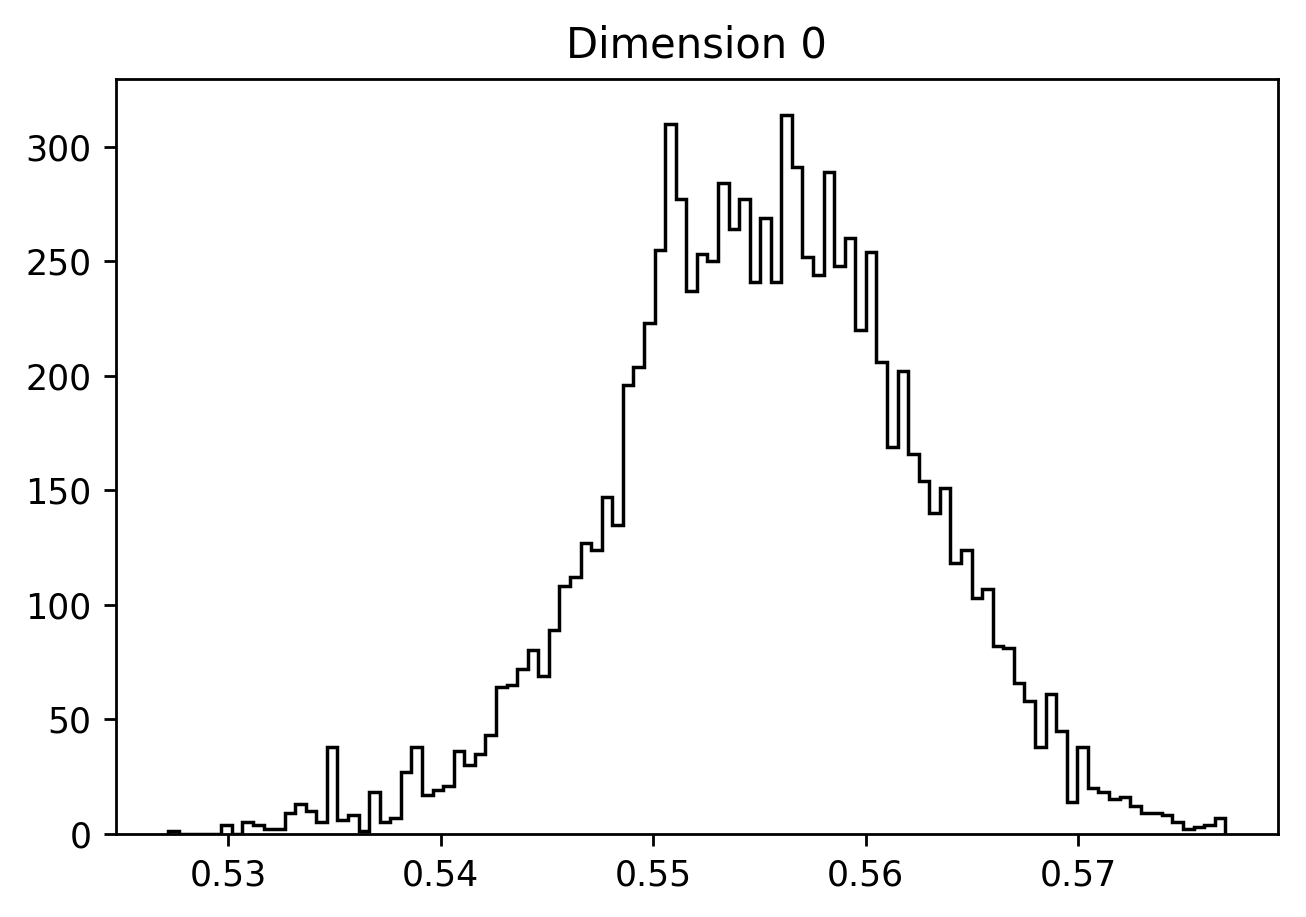

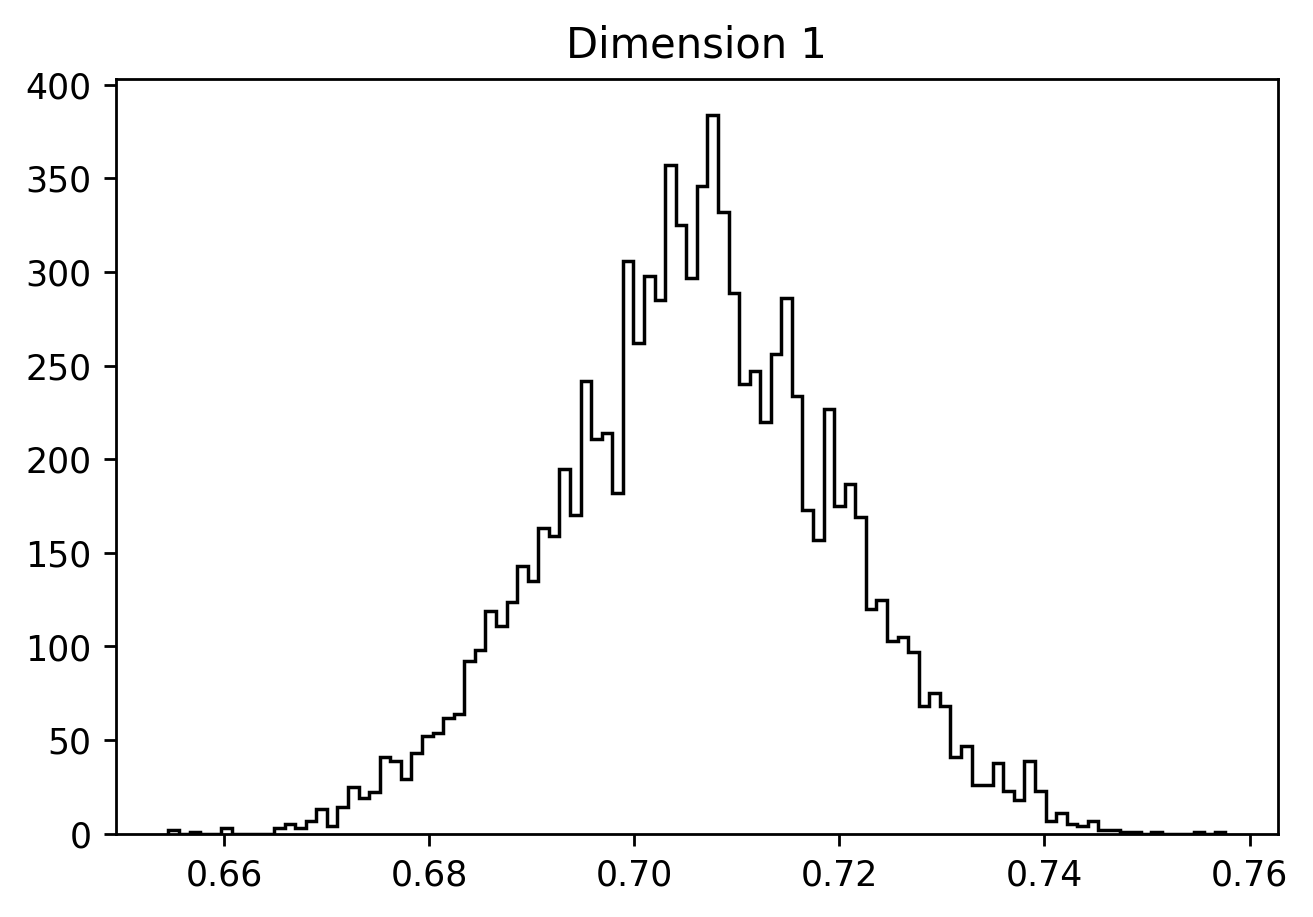

In [16]:
for i in range(ndim):
    plt.figure()
    plt.hist(sampler.flatchain[:,i], 100, color="k", histtype="step")
    plt.title("Dimension {0:d}".format(i))

In [17]:
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))

Mean acceptance fraction: 0.713


### Use likelihood object to make several useful plots

In [18]:
# get mean of chain
mcmc_mean=np.mean(sampler.flatchain,axis=0)
print('mean point',mcmc_mean)

mean point [ 0.5551907  0.7059593]


In [19]:
like.update_parameters(mcmc_mean)

In [20]:
for p in like.free_params:
    print(p.name,p.value)

ln_tau_0 -0.922404650753
ln_tau_1 4.41191860624


Text(0, 0.5, '<F>')

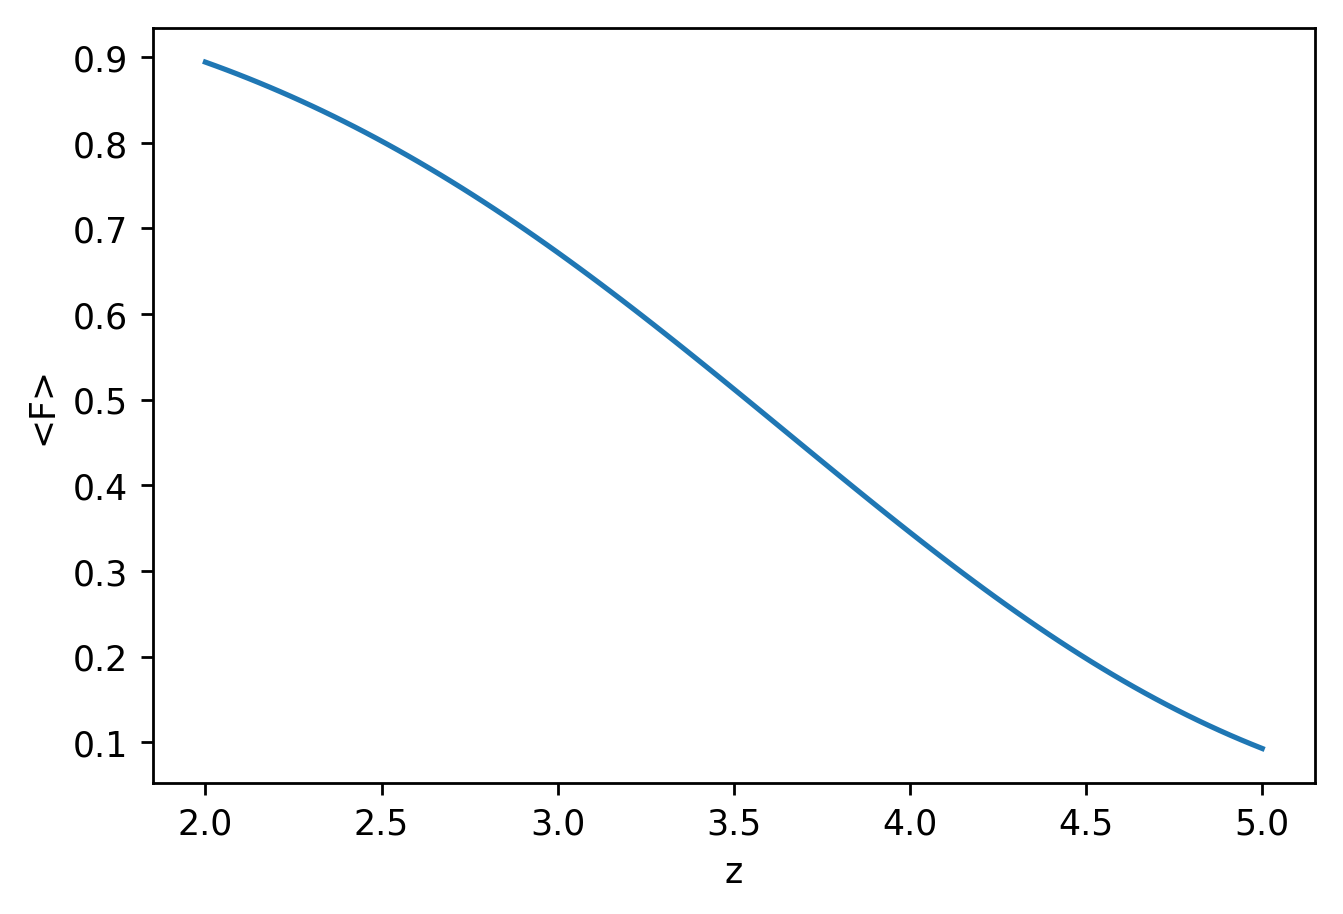

In [21]:
z=np.linspace(2.0,5.0,100)
mf=like.theory.mf_model.get_mean_flux(z)
plt.plot(z,mf)
plt.xlabel('z')
plt.ylabel('<F>')

Text(0, 0.5, '$T_0(z)$ [K]')

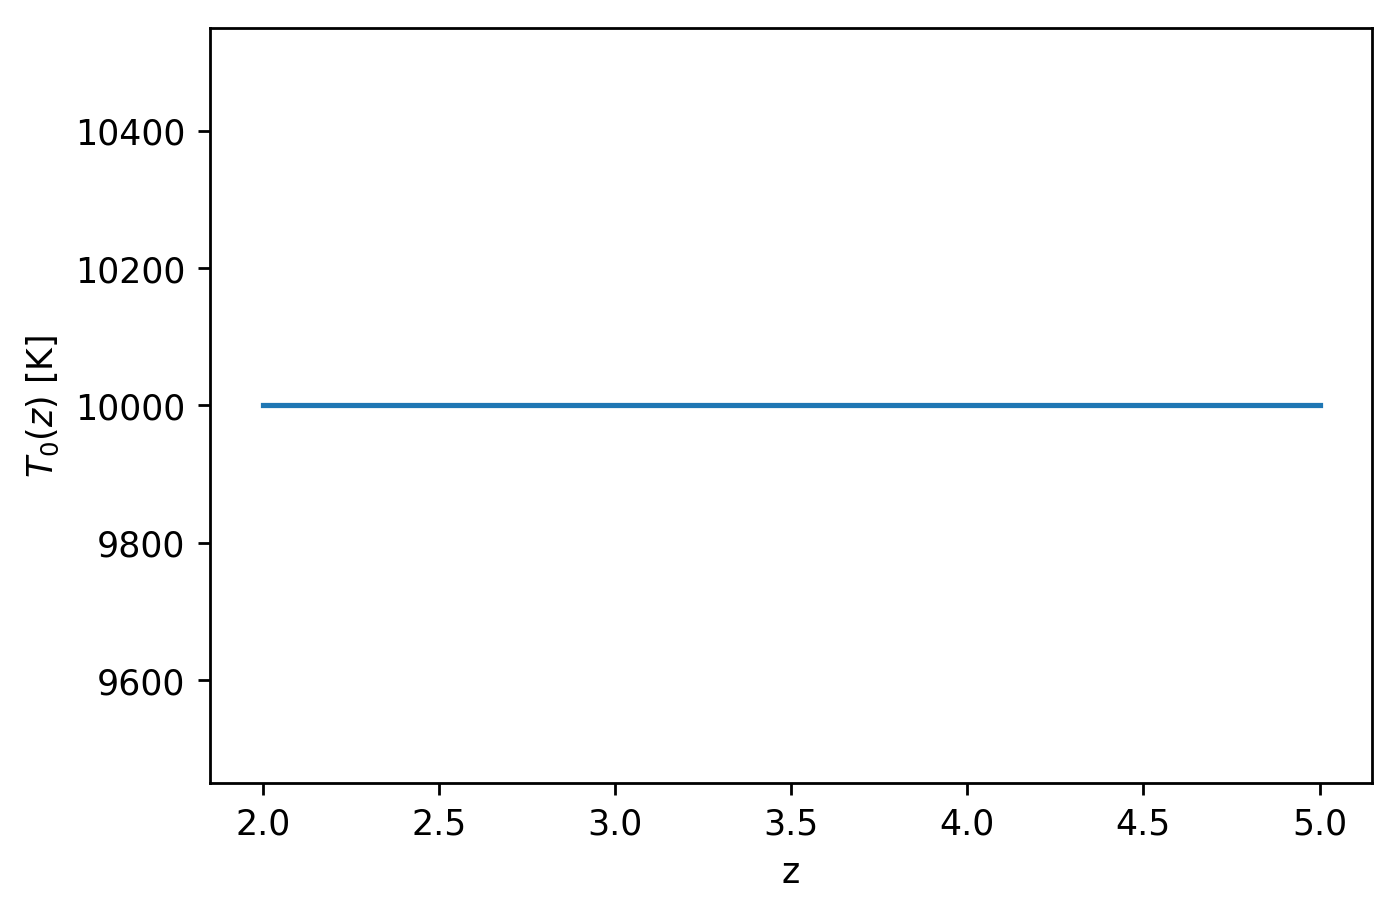

In [22]:
T0=like.theory.T_model.get_T0(z)
plt.plot(z,T0)
plt.xlabel('z')
plt.ylabel(r'$T_0(z)$ [K]')

Text(0, 0.5, '$\\sigma_T(z)$ [km/s]')

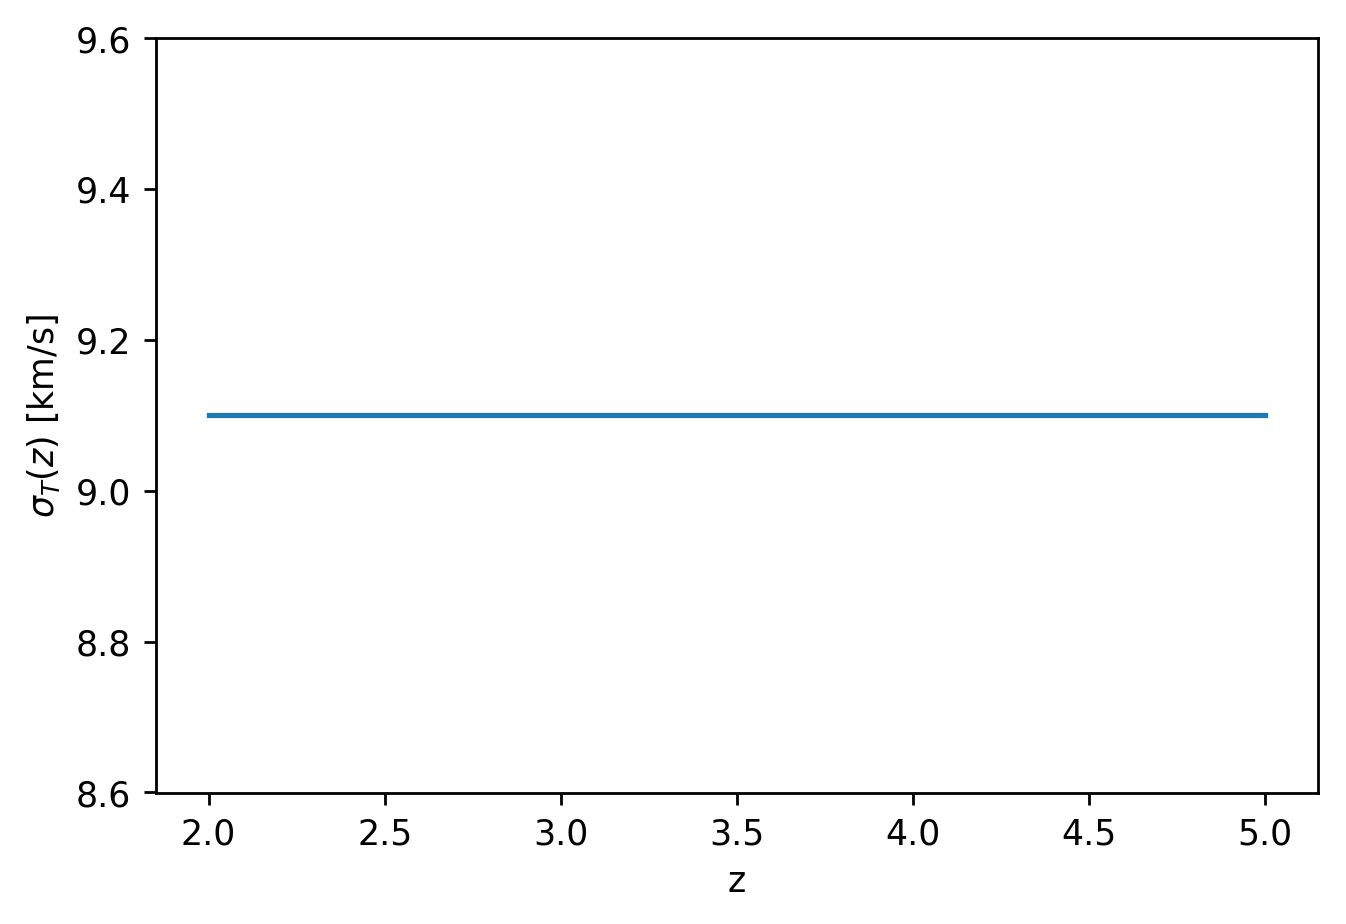

In [23]:
sigT=like.theory.T_model.get_sigT_kms(T0)
plt.plot(z,sigT)
plt.xlabel('z')
plt.ylabel(r'$\sigma_T(z)$ [km/s]')

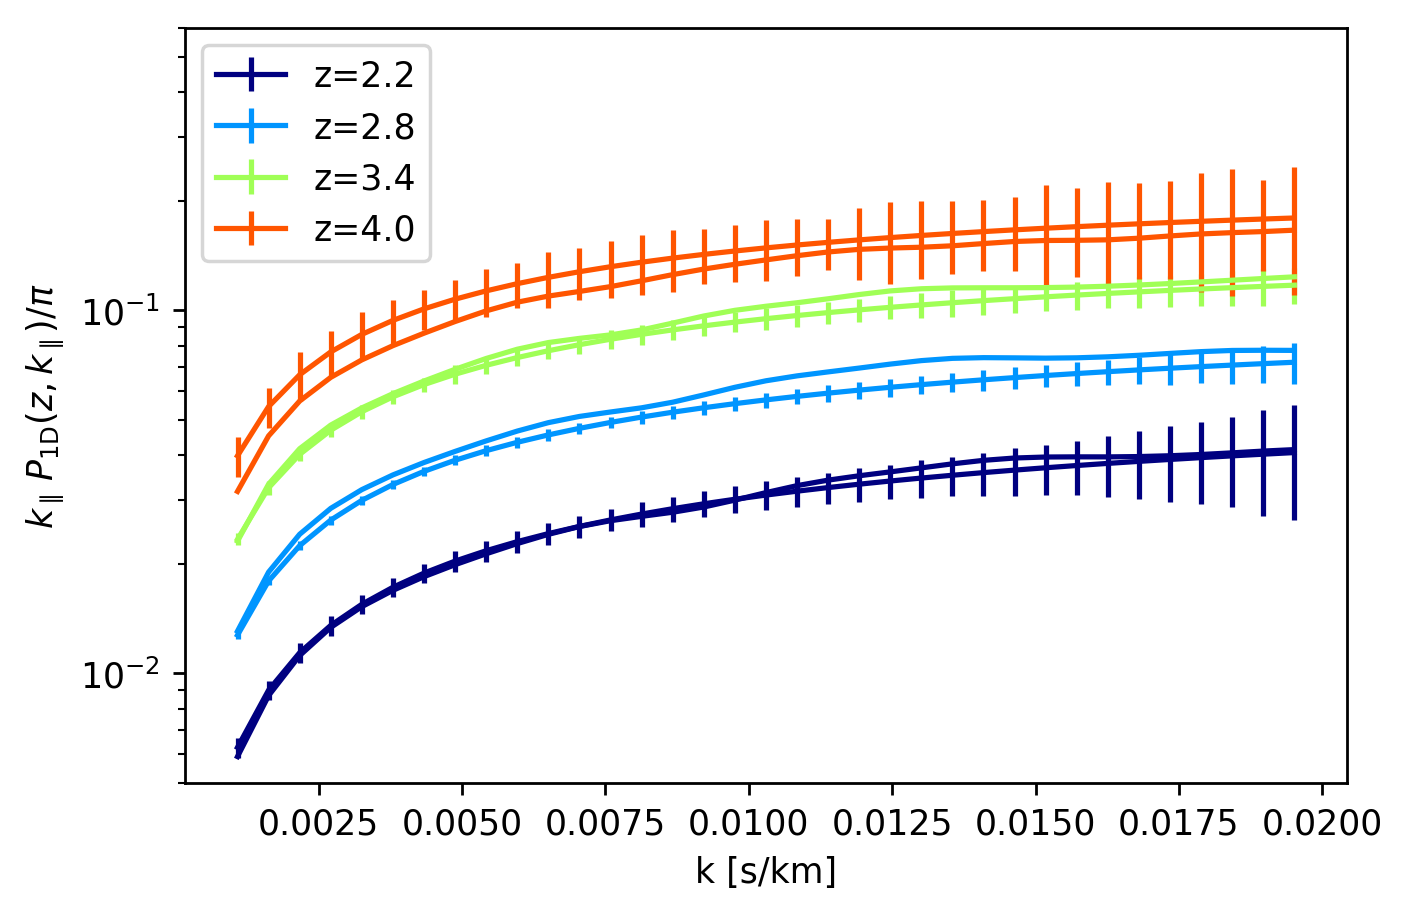

In [24]:
like.plot_p1d()

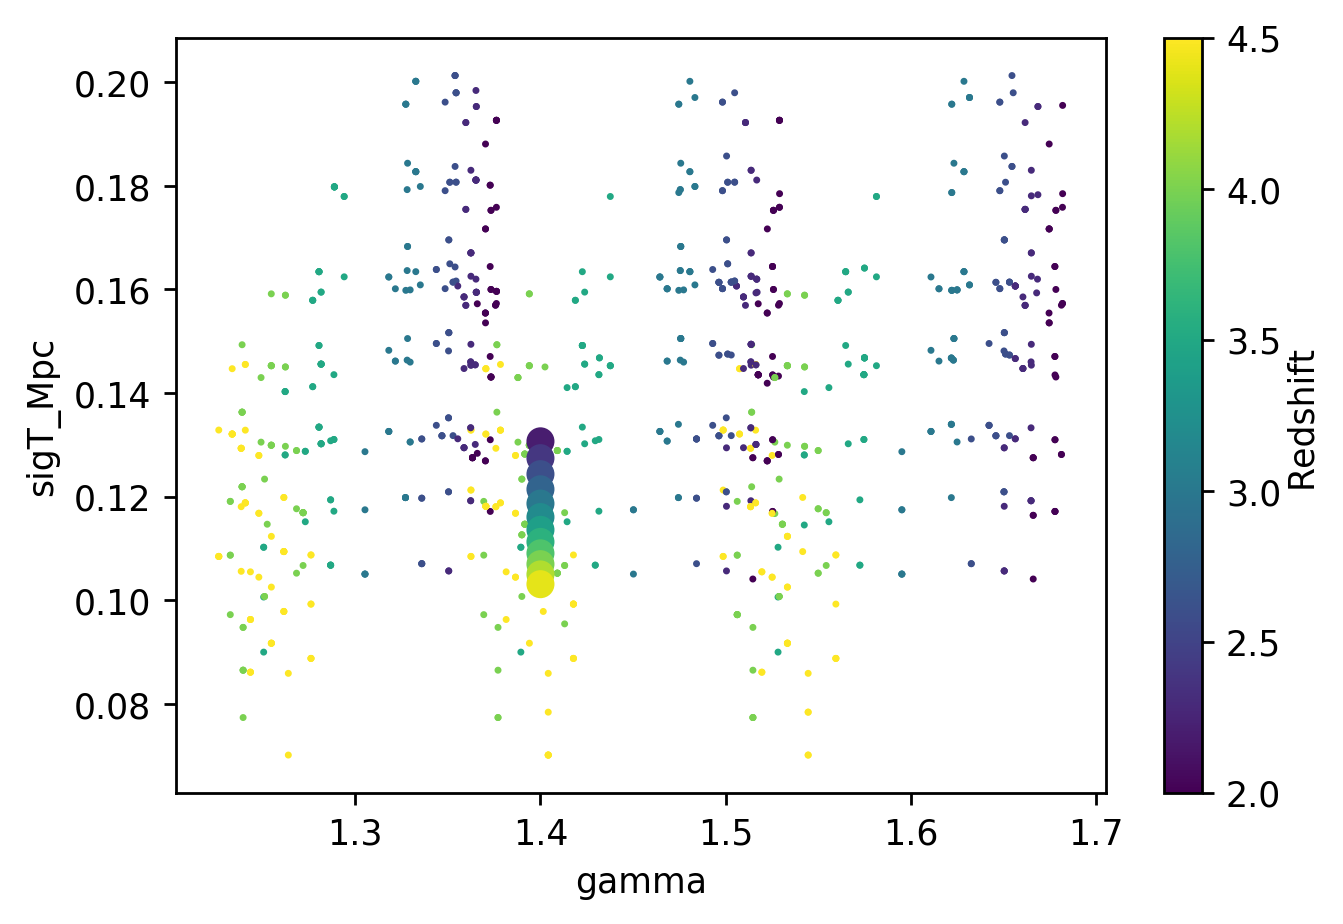

In [25]:
like.overplot_emulator_calls('gamma','sigT_Mpc',linP_Mpc_params=linP_Mpc_params)

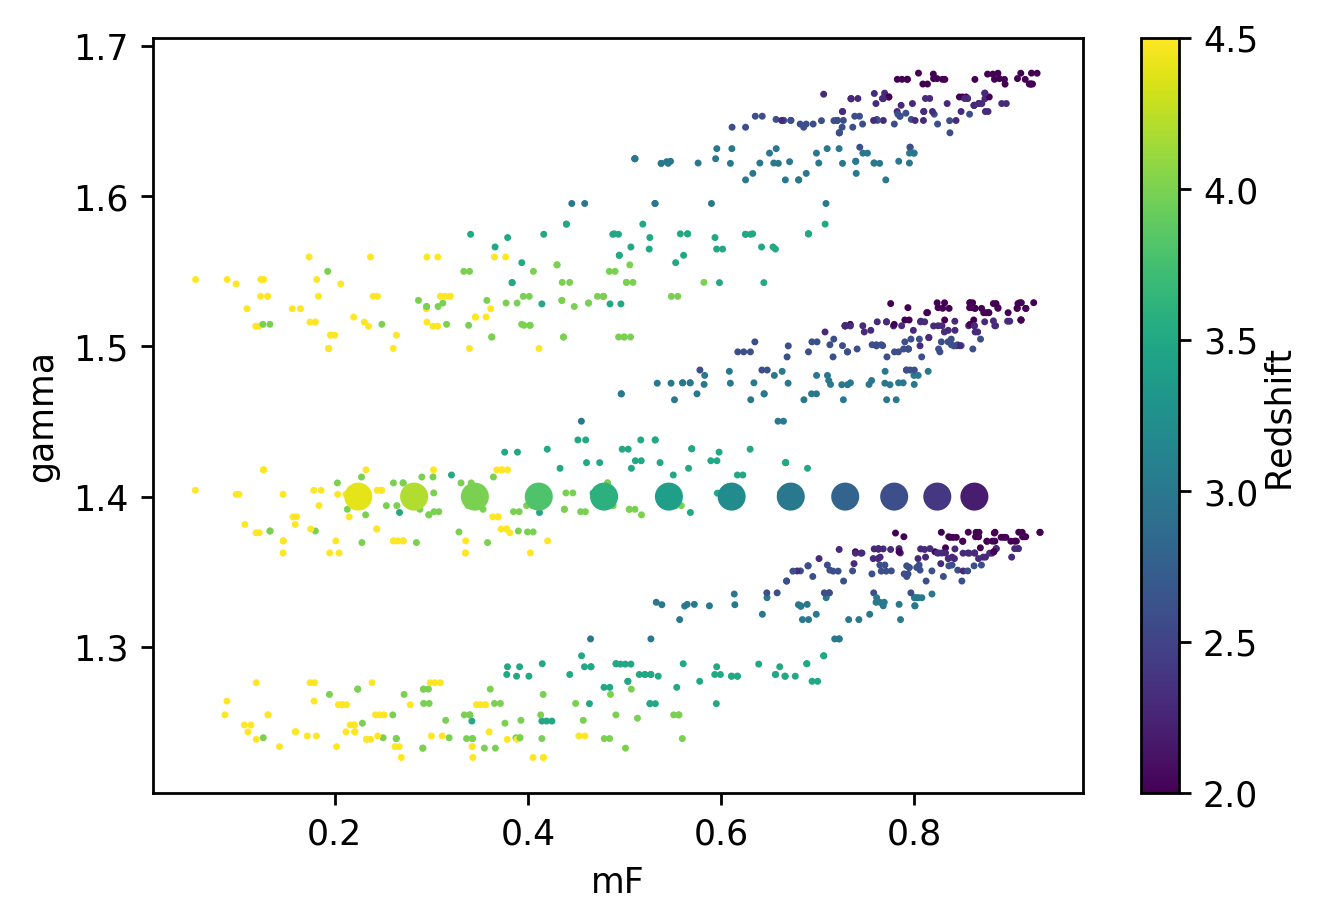

In [26]:
like.overplot_emulator_calls('mF','gamma',linP_Mpc_params=linP_Mpc_params)

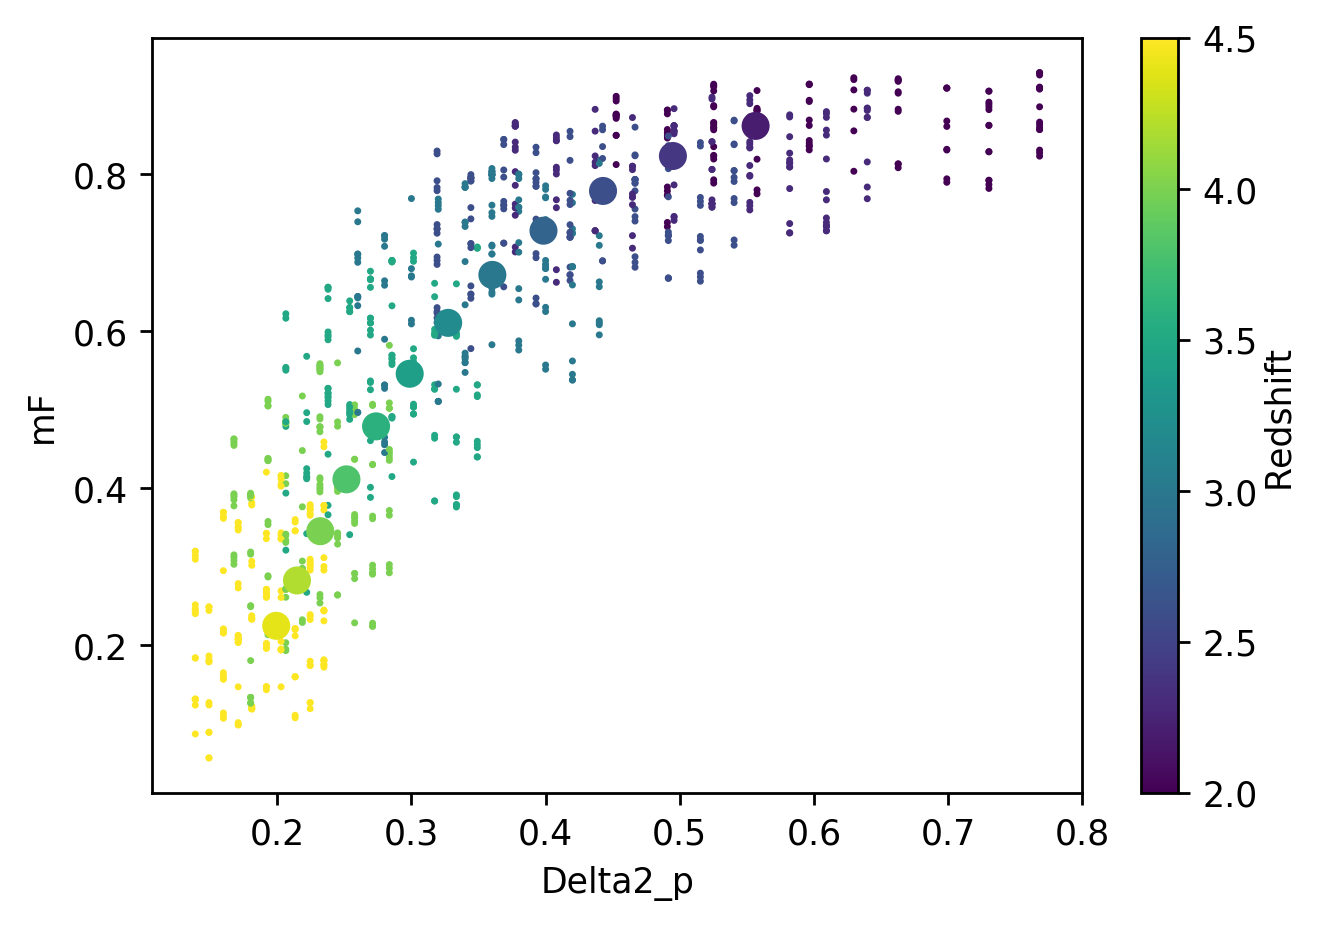

In [27]:
like.overplot_emulator_calls('Delta2_p','mF',linP_Mpc_params=linP_Mpc_params)

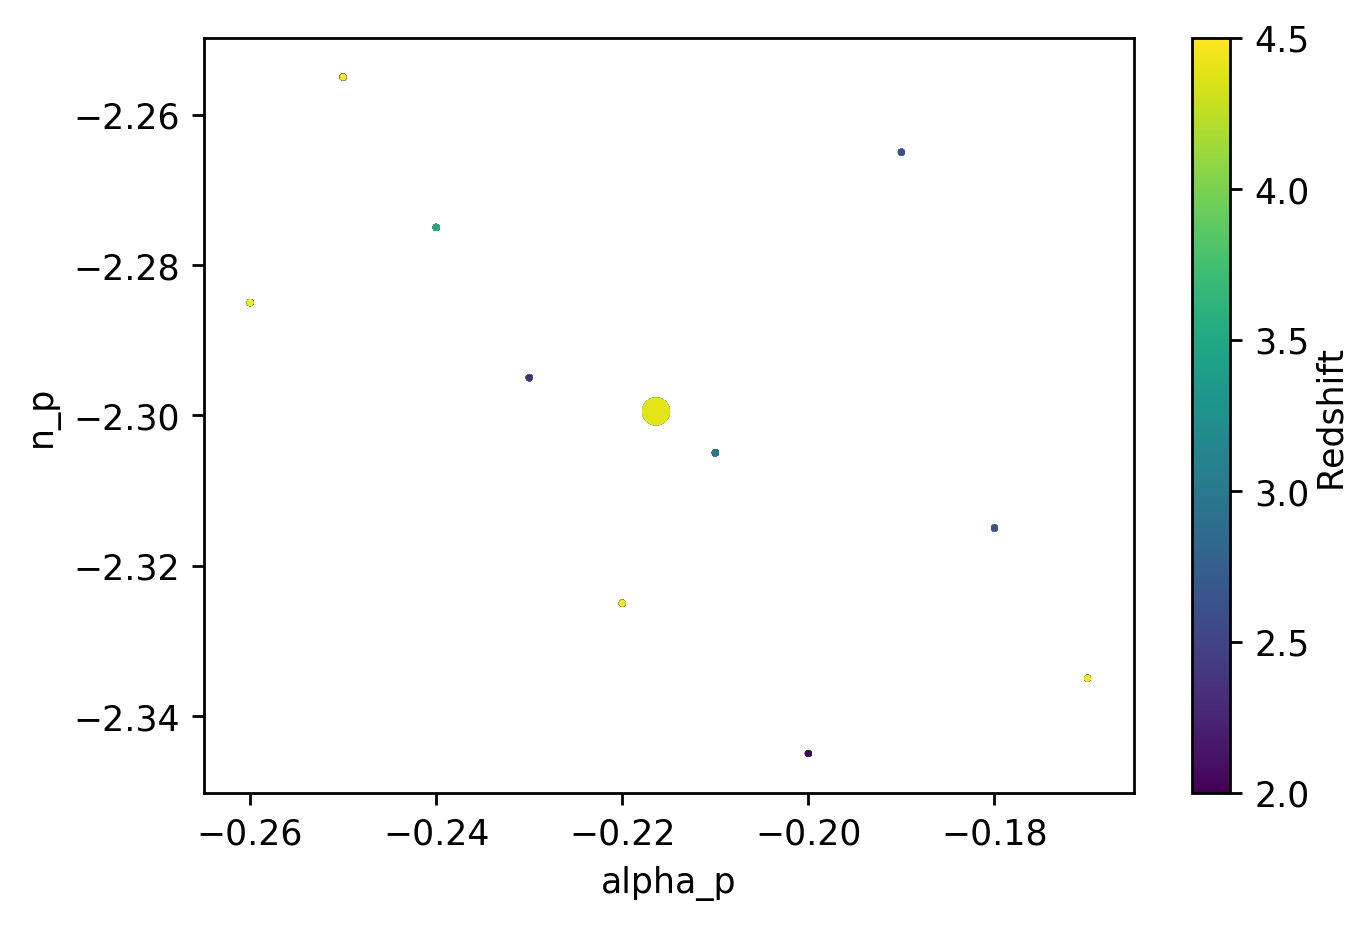

In [28]:
like.overplot_emulator_calls('alpha_p','n_p',linP_Mpc_params=linP_Mpc_params)

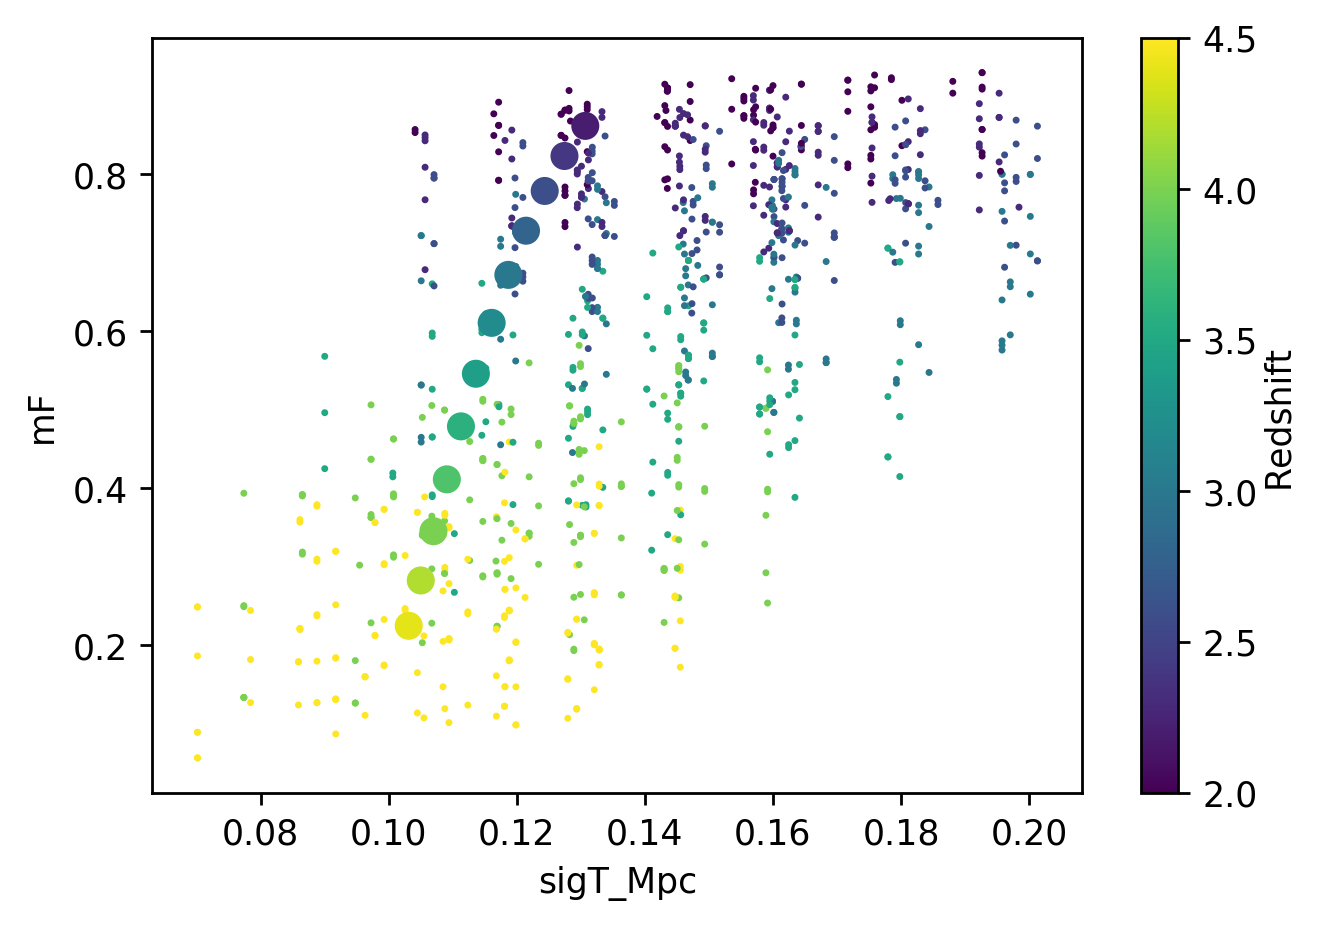

In [29]:
like.overplot_emulator_calls('sigT_Mpc','mF',linP_Mpc_params=linP_Mpc_params)

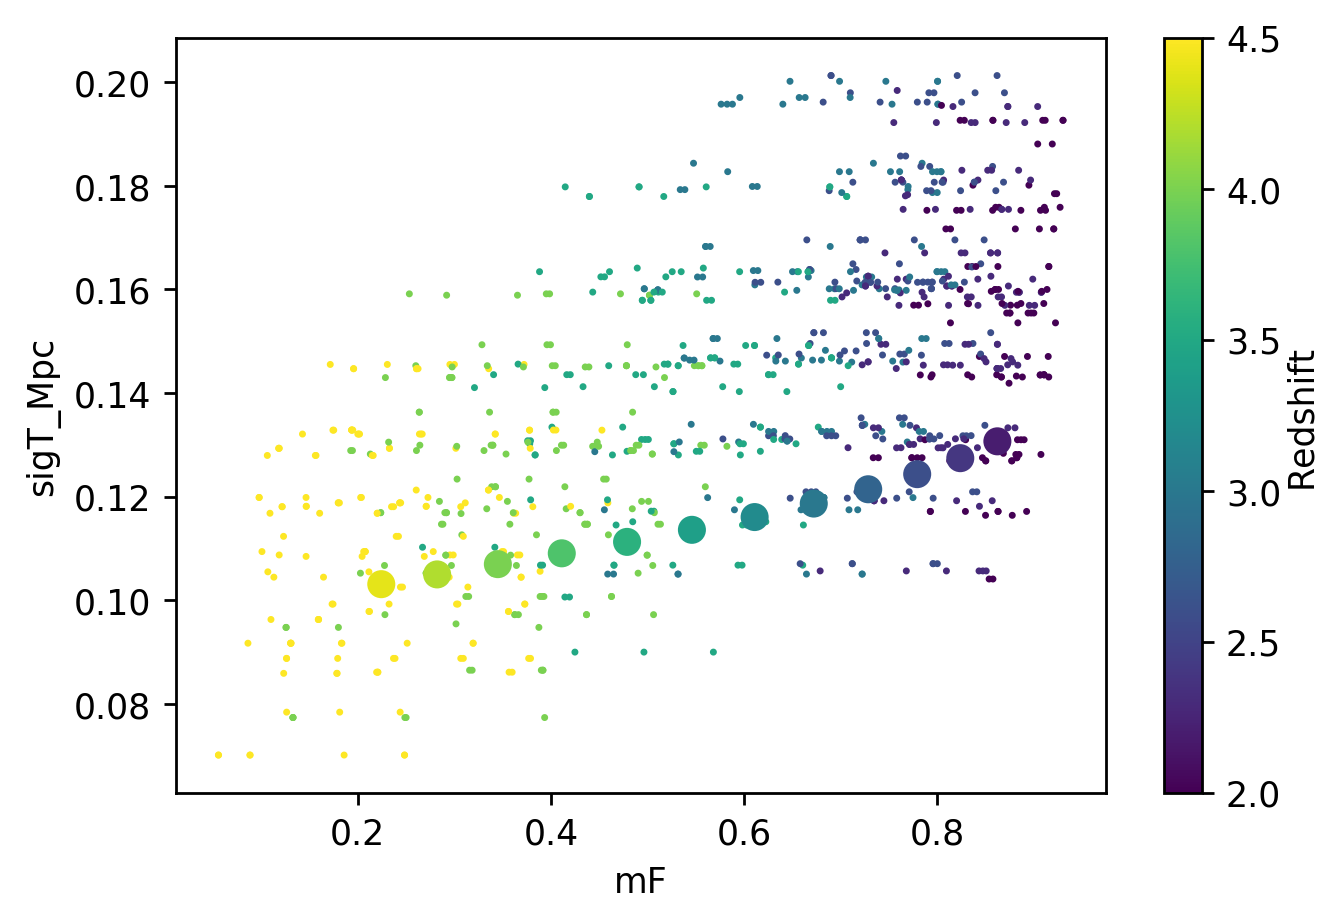

In [30]:
like.overplot_emulator_calls('mF','sigT_Mpc',linP_Mpc_params=linP_Mpc_params)